# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 
Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

**Основные шаги:**

- Загрузите данные.
- Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
- Подготовьте выборки для обучения моделей.
- Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
- Проанализируйте время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.

# Описание данных

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

## Подготовка данных

In [1]:
#!pip install -U sklearn

In [2]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import catboost
import lightgbm
import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
print('LGBM vers.:', lightgbm.__version__)
print('sklearn vers.:', sklearn.__version__)

RANDOM_STATE = 12345

LGBM vers.: 3.3.5
sklearn vers.: 1.2.2


In [3]:
pth1 = '/Users/ramilvaleev/Desktop/Yandex Projects/Проекты в работе/Цена авто/autos.csv'
pth2 = '/datasets/autos.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
def check_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(10))
    display(df.describe())
    df.info()
    print('\nКоличество пропусков:')
    print(df.isna().sum())

In [5]:
check_df(data)

Количество стобцов: 16
Количество строк: 354369


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Вывод:**

Столбцы, требующие обработки:

- VehicleType. Восстановим пропущенные значения по самому популярному типу для данной модели.
- Gearbox. Восстановим пропущенные значения по самому популярному типу для данной модели.
- Power. Восстановим пропущенные значения по самому популярному типу для данной модели и удалим выбросы.
- FuelType. Восстановим пропущенные значения по самому популярному типу для данной модели.
- Repaired. Для всех NaN установим значение 'no'.
- RegistrationYear. Обработаем выбросы.
- Model. Для всех NaN установим значение 'unknown'.
- Price. В целевом столбце присутствуют нули, такие строки придется удалить.
- Brand. В столбце присутствует значение sonstige_autos, это "другие авто" по-немецки, в этих строках отсутствует как бренд так и модель, цену не спрогнозировать, будем удалять.

Приведем названия столбцов в змеиный регистр.

In [6]:

data.columns = data.columns.str.lower()

data = data.rename(columns={'datecrawled':'date_crawled', 
                        'vehicletype':'vehicle_type', 
                        'registrationyear':'registration_year', 
                        'registrationmonth':'registration_month', 
                        'fueltype':'fuel_type', 
                        'datecreated':'date_created',
                        'numberofpictures': 'number_of_pictures',
                        'postalcode':'postal_code',
                        'lastseen':'last_seen'})

Удалим столбцы, которые нам не понадобятся.

In [7]:
data = data.drop(['number_of_pictures', 'postal_code',\
                  'last_seen', 'registration_month', 'date_crawled', 'date_created'], axis=1)

In [8]:
data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


- Удалим строки с отсутствующим целевым признаком.
- Удалим строки где бренд = sonstige_autos, т.к. это "другие авто" по-немецки, в этих строках отсутствует как бренд так и модель, цену не спрогнозировать, признаки неинформативны.

In [9]:
data = data.loc[data['price'] > 0]
data = data.loc[data['brand'] != 'sonstige_autos']
len(data)

340750

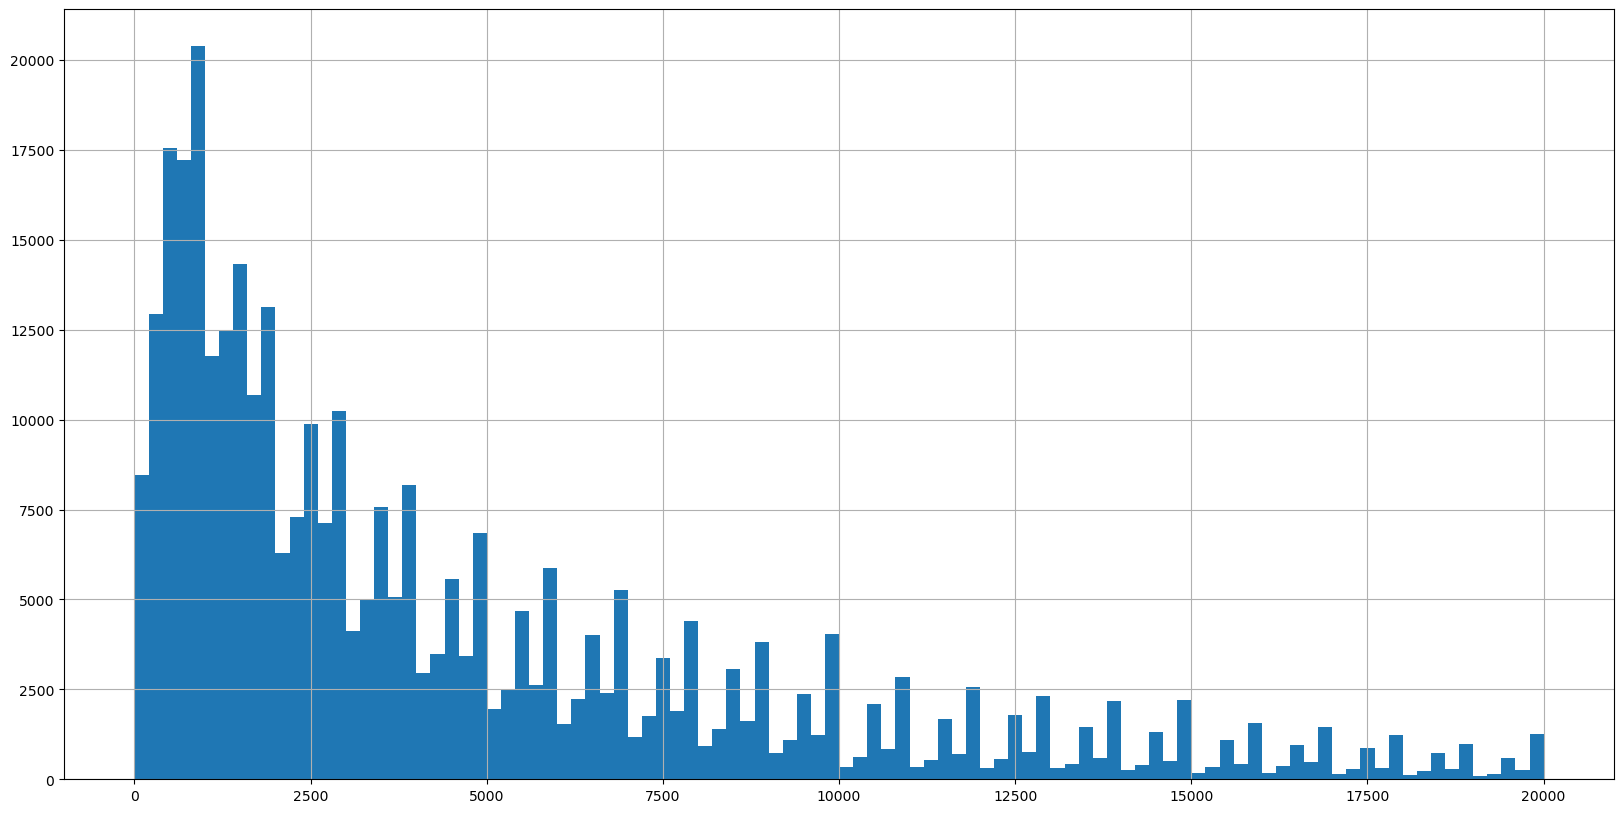

In [10]:
data['price'].hist(figsize=(20, 10), bins=100);

`gasoline` и `petrol` это бензин, оставим только одно значение.

In [11]:
data['fuel_type'] = data['fuel_type'].replace(['gasoline'],'petrol')

Предположим что все кто не ответил на вопрос о ремонте просто с ним не сталкивались и не сочли ответ необходимым.

In [12]:
data['repaired'] = data['repaired'].fillna('no')

In [13]:
data['model'] = data['model'].replace(['other'],np.nan)
data['power'] = data['power'].replace([0],np.nan)

In [14]:
data[data['power'].isna() & data['fuel_type'].isna() & data['model'].isna() & data['gearbox'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
538,2600,NaN,2005,NaN,NaN,NaN,125000,NaN,chevrolet,no
552,50,NaN,1985,NaN,NaN,NaN,150000,NaN,trabant,no
1076,45,NaN,2015,NaN,NaN,NaN,5000,NaN,mini,no
1236,1200,NaN,2000,NaN,NaN,NaN,150000,NaN,bmw,yes
1374,500,NaN,2000,NaN,NaN,NaN,5000,NaN,mercedes_benz,no
...,...,...,...,...,...,...,...,...,...,...
352989,1200,NaN,2000,NaN,NaN,NaN,150000,NaN,bmw,no
353302,150,NaN,2000,NaN,NaN,NaN,150000,NaN,hyundai,yes
353727,1,NaN,2000,NaN,NaN,NaN,150000,NaN,bmw,no
353912,800,NaN,1970,NaN,NaN,NaN,150000,NaN,trabant,no


In [15]:
len(data)

340750

Удалим строки в которых пропущены значения сразу в 3 из 5 столбцов, на таких данных не построить прогноз.

In [16]:
data = data.dropna(subset=['power', 'fuel_type', 'model', 'gearbox'], thresh = 3)

In [17]:
len(data) 

316781

Удалили около 7 процентов данных.

In [18]:
data.isna().sum()

price                    0
vehicle_type         22181
registration_year        0
gearbox               3865
power                17375
model                26572
kilometer                0
fuel_type            14396
brand                    0
repaired                 0
dtype: int64

Создадим функцию для заполнения пропусков

In [19]:
def fillna_by_model(row, row_number, dicts):
    model = row[5]
    fill_value = row[row_number]
    if row[row_number] == 'empty':
        fill_value = dicts[model]
        
    return fill_value

Заполнить пропуски в моделях не представляется возможным, заполним их категорией `unknown`.

In [20]:
data['model'] = data['model'].fillna('unknown')

Cледующие столбцы заполним самым популярным значением по модели авто.

In [21]:
data[['vehicle_type', 'power', 'gearbox', 'fuel_type']] = data\
[['vehicle_type', 'power', 'gearbox', 'fuel_type']].fillna('empty')

columns = [['vehicle_type', 1], ['power', 4], ['gearbox', 3], ['fuel_type', 7]]
for col, col_num in columns:
    model_dict = data.groupby('model')[col].agg(lambda x:x.value_counts().index[0]).to_dict()
    data[col] = data.apply(
                            fillna_by_model, 
                            args = [col_num, model_dict],
                            axis=1)

In [22]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,75.0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190.0,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,petrol,jeep,no
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,petrol,skoda,no


Осталось незначительное количество строк со значением `empty` в мощности и типе кузова, удалим их.

In [23]:
data['power'] = data['power'].replace(['empty'], np.nan)
data['vehicle_type'] = data['vehicle_type'].replace(['empty'], np.nan)
data = data.dropna()

Посмотрев на данные можно сказать, что мощность двигателя выше 550л.с. можно считать выбросом, аналогично с мощностью ниже 25л.с.

In [24]:
#(data[data['power'] > 500]).sample(50)
data = data.query('25 < power < 551')

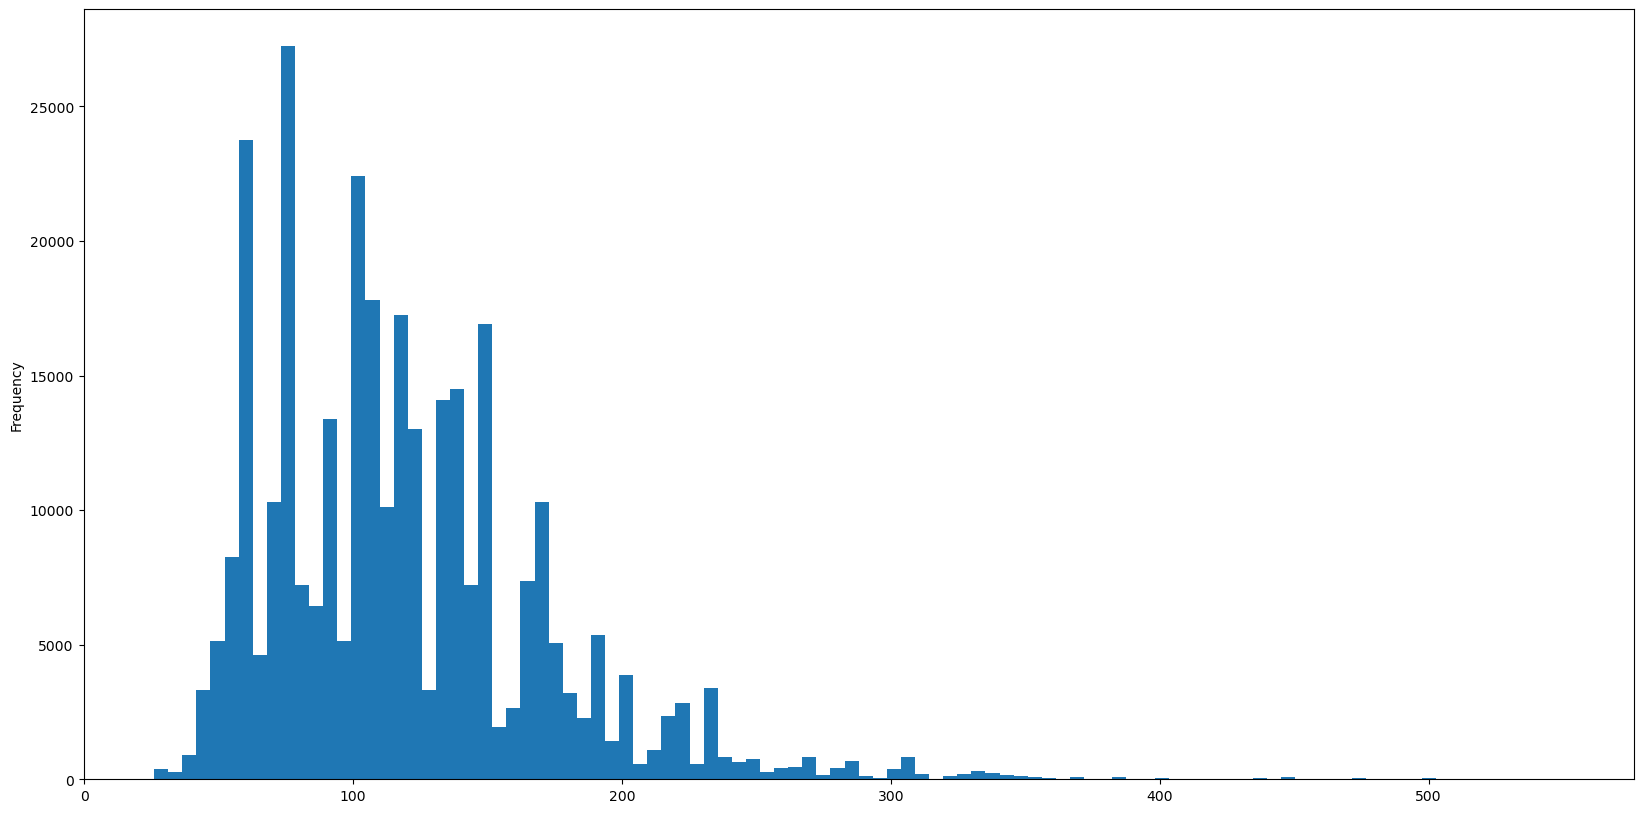

In [25]:
data['power'].plot(kind='hist', bins=100, figsize=(20, 10));

Год регистрации позже 2016 можно считать выбросом, так как все объявления были созданы с 2014 по 2016 слева данные ограничим 1960 годом, все что ниже будем считать выбросами.

In [26]:
#(data[data['registration_year'] > 2016]).sample(50)
data = data.query('1959 < registration_year < 2017')

In [27]:
data.describe()

,price,registration_year,power,kilometer
count,305397.000000,305397.000000,305397.000000,305397.000000
mean,4746.148076,2002.841367,119.695498,128763.461986
std,4574.028611,6.272065,52.940312,36462.791232
min,1.000000,1960.000000,26.000000,5000.000000
25%,1299.000000,1999.000000,75.000000,125000.000000
50%,3000.000000,2003.000000,110.000000,150000.000000
75%,6900.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,550.000000,150000.000000


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305397 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              305397 non-null  int64  
 1   vehicle_type       305397 non-null  object 
 2   registration_year  305397 non-null  int64  
 3   gearbox            305397 non-null  object 
 4   power              305397 non-null  float64
 5   model              305397 non-null  object 
 6   kilometer          305397 non-null  int64  
 7   fuel_type          305397 non-null  object 
 8   brand              305397 non-null  object 
 9   repaired           305397 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 25.6+ MB


**Вывод:**

- Была изучена таблица данных.
- Выведены аномальные и пропущенные значения.
- Отобраны небходимые столбцы для обучения модели.
- Заполнены пропуски в столбцах и удалены некорректные значения.
- Выигрыш в памяти составляет 40%, что ускорит обращение к памяти при обучении модели.

In [28]:
features = data.drop(['price'], axis=1)
target = data['price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

print(features_train.shape)
features_test.shape

(229047, 9)


(76350, 9)

Масштабируем числовые признаки и трансформируем категориальные признаки.

In [29]:
# OneHotEncoding
categorial = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
numeric = ['registration_year', 'power', 'kilometer']
col_trans_ohe = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), categorial),
    (StandardScaler(), numeric),
    remainder='passthrough'
)

features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

col_trans_ohe.fit(features_train)
features_train_ohe = col_trans_ohe.transform(features_train)
features_test_ohe = col_trans_ohe.transform(features_test)

# OrdinalEncoding

col_trans_oe = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorial),
    (StandardScaler(), numeric),
    remainder='passthrough'
)

features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

col_trans_oe.fit(features_train)
features_train_oe = col_trans_oe.transform(features_train)
features_test_oe = col_trans_oe.transform(features_test)

## Обучение моделей

In [30]:
def find_RMSE(model, features_inp, target_inp, grid_param):
    model_grid = GridSearchCV(
        estimator = model, param_grid = grid_param, cv=5, scoring='neg_root_mean_squared_error'
    )
    model_grid.fit(features_inp, target_inp)
    print(model_grid.best_params_)
    return model_grid.best_score_ * -1

### Линейная регрессия

In [31]:
%%time
grid_param = {'n_jobs': [1]}
lr_regressor = LinearRegression()
find_RMSE(lr_regressor, features_train_ohe, target_train, grid_param)

{'n_jobs': 1}
CPU times: user 1min 16s, sys: 1.75 s, total: 1min 17s
Wall time: 20 s


2623.2484401117135

### Дерево решений

In [32]:
%%time
dt_regressor = DecisionTreeRegressor() 

grid_param = {'max_depth':[x for x in range(1, 15)], 
               'random_state':[RANDOM_STATE]}

find_RMSE(dt_regressor, features_train_oe, target_train, grid_param)

{'max_depth': 14, 'random_state': 12345}
CPU times: user 17.1 s, sys: 276 ms, total: 17.4 s
Wall time: 17 s


1848.2518136259139

### Слуйчайный лес

In [33]:
%%time
# Подберем параметры для модели случайного леса
grid_param = {'n_estimators': [int(x) for x in range(20, 121, 20)],
              'max_depth': [x for x in range(1, 20, 2)],
              'random_state':[RANDOM_STATE],
              'n_jobs': [3]}

rf_regressor = RandomForestRegressor()

find_RMSE(rf_regressor, features_train_oe, target_train, grid_param)

{'max_depth': 19, 'n_estimators': 120, 'n_jobs': 3, 'random_state': 12345}
CPU times: user 3min 43s, sys: 56.3 s, total: 4min 40s
Wall time: 27min 30s


1580.8045164377422

### LightGBM

In [31]:
%%time
lgbm_regressor = LGBMRegressor()

grid_param = [{'n_estimators': [int(x) for x in range(60, 121, 20)],
                'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[RANDOM_STATE],
                'n_jobs': [3]}]

find_RMSE(lgbm_regressor, features_train_oe, target_train, grid_param)

{'learning_rate': 0.3, 'n_estimators': 120, 'n_jobs': 3, 'num_leaves': 200, 'random_state': 12345}
CPU times: user 5min 53s, sys: 5.77 s, total: 5min 59s
Wall time: 2min 1s


1538.5531188760958

### CatBoost

In [58]:
%%time
cb_regressor = CatBoostRegressor() 

grid_param = {'iterations' : [300],
              'learning_rate':[0.1, 0.5, 0.8],
              'random_state':[RANDOM_STATE],
              'loss_function':['RMSE'],
              'verbose':[100]}

find_RMSE(cb_regressor, features_train_oe, target_train, grid_param)

0:	learn: 4269.6316428	total: 23ms	remaining: 6.87s
100:	learn: 1775.3255704	total: 681ms	remaining: 1.34s
200:	learn: 1687.3800631	total: 1.35s	remaining: 665ms
299:	learn: 1641.3109065	total: 2s	remaining: 0us
0:	learn: 4276.8827528	total: 9.85ms	remaining: 2.94s
100:	learn: 1773.7533301	total: 663ms	remaining: 1.3s
200:	learn: 1687.6741134	total: 1.31s	remaining: 644ms
299:	learn: 1642.9972659	total: 1.94s	remaining: 0us
0:	learn: 4279.3853544	total: 9.28ms	remaining: 2.77s
100:	learn: 1781.0592600	total: 658ms	remaining: 1.3s
200:	learn: 1691.7122669	total: 1.29s	remaining: 638ms
299:	learn: 1643.3722935	total: 1.92s	remaining: 0us
0:	learn: 4279.5930181	total: 12.5ms	remaining: 3.73s
100:	learn: 1777.4608194	total: 660ms	remaining: 1.3s
200:	learn: 1689.0723409	total: 1.3s	remaining: 640ms
299:	learn: 1642.9289311	total: 1.95s	remaining: 0us
0:	learn: 4272.4274783	total: 12.9ms	remaining: 3.85s
100:	learn: 1774.5889448	total: 654ms	remaining: 1.29s
200:	learn: 1688.3933082	total: 

1591.7857880583258

**Вывод:**
    
Были изучены 5 регрессионных моделей. Зафиксированы лучшие гиперпараметры и время их выполнения.

## Анализ моделей

### Линейная регрессия

In [31]:
%%time
lr_regressor = LinearRegression() 
lr_regressor.fit(features_train_ohe, target_train)

CPU times: user 16.4 s, sys: 681 ms, total: 17.1 s
Wall time: 4.4 s


LinearRegression()

In [32]:
%%time
pred = lr_regressor.predict(features_test_ohe)
rmse_lr = mean_squared_error(target_test, pred, squared=False)
rmse_lr

CPU times: user 10.8 ms, sys: 2.23 ms, total: 13 ms
Wall time: 3.53 ms


2599.4410071136335

### Дерево решений

In [33]:
%%time
dt_regressor = DecisionTreeRegressor(max_depth=14, random_state=RANDOM_STATE) 
dt_regressor.fit(features_train_oe, target_train)

CPU times: user 990 ms, sys: 21.1 ms, total: 1.01 s
Wall time: 512 ms


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [34]:
%%time
pred = dt_regressor.predict(features_test_oe)
rmse_dt = mean_squared_error(target_test, pred, squared=False)
rmse_dt

CPU times: user 13.4 ms, sys: 1.7 ms, total: 15.1 ms
Wall time: 13.2 ms


1785.5488277240866

### Слуйчайный лес

In [35]:
%%time
rf_regressor = RandomForestRegressor(n_estimators=120, max_depth=19, random_state=RANDOM_STATE) 
rf_regressor.fit(features_train_oe, target_train)

CPU times: user 50.5 s, sys: 568 ms, total: 51.1 s
Wall time: 51.4 s


RandomForestRegressor(max_depth=19, n_estimators=120, random_state=12345)

In [36]:
%%time
pred = rf_regressor.predict(features_test_oe)
rmse_rf = mean_squared_error(target_test, pred, squared=False)
rmse_rf

CPU times: user 2.01 s, sys: 21.9 ms, total: 2.03 s
Wall time: 2.03 s


1543.2610672337987

### LightGBM

In [37]:
%%time
lgbm_regressor = LGBMRegressor(learning_rate = 0.3, n_estimators = 120, num_leaves=200, n_jobs = 3, random_state=RANDOM_STATE) 
lgbm_regressor.fit(features_train_oe, target_train)

CPU times: user 2.5 s, sys: 40.2 ms, total: 2.54 s
Wall time: 880 ms


LGBMRegressor(learning_rate=0.3, n_estimators=120, n_jobs=3, num_leaves=200,
              random_state=12345)

In [38]:
%%time
pred = lgbm_regressor.predict(features_test_oe)
rmse_lgbm = mean_squared_error(target_test, pred, squared=False)
rmse_lgbm

CPU times: user 1.18 s, sys: 4.58 ms, total: 1.19 s
Wall time: 397 ms


1515.1083782057917

### CatBoost

In [39]:
%%time
cb_regressor = CatBoostRegressor(iterations = 300, learning_rate=0.5, verbose=100,
                         loss_function='RMSE', random_state=RANDOM_STATE)
cb_regressor.fit(features_train_oe, target_train)

0:	learn: 3231.0790234	total: 76.2ms	remaining: 22.8s
100:	learn: 1615.3959390	total: 1.02s	remaining: 2.01s
200:	learn: 1538.0028230	total: 1.89s	remaining: 931ms
299:	learn: 1494.9282858	total: 2.9s	remaining: 0us
CPU times: user 16.6 s, sys: 432 ms, total: 17 s
Wall time: 3.48 s


In [40]:
%%time
pred = cb_regressor.predict(features_test_oe)
rmse_cb = mean_squared_error(target_test, pred, squared=False)
rmse_cb

CPU times: user 212 ms, sys: 6.02 ms, total: 218 ms
Wall time: 180 ms


1580.492161557221

In [42]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'RandomForestRegressor',
         'LGBMRegressor',
         'CatBoostRegressor']
tabledata = {'RMSE на обучающей выборке, евро':[2623,
                            1848,
                            1581,
                            1539,
                            1592],
        'Время обучения на gsCV, сек':[20,
                                     17,
                                     1650,
                                     61,
                                     46.6],
        'RMSE модели на тестовой выборке, евро':[round(rmse_lr),
                                                round(rmse_dt),
                                                round(rmse_rf),
                                                round(rmse_lgbm),
                                                round(rmse_cb)],
        'Время обучения модели, сек':[4.4,
                                      0.512,
                                      51.4,
                                      0.88,
                                      3.48],
        'Время предсказания модели, сек':[0.00353,
                                          0.0132,
                                          2.03,
                                          0.397,
                                          0.180]}
df= pd.DataFrame(data=tabledata, index=index)
df

,"RMSE на обучающей выборке, евро","Время обучения на gsCV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек"
LinearRegression,2623,20.0,2599,4.400,0.00353
DecisionTreeRegressor,1848,17.0,1786,0.512,0.01320
RandomForestRegressor,1581,1650.0,1543,51.400,2.03000
LGBMRegressor,1539,61.0,1515,0.880,0.39700
CatBoostRegressor,1592,46.6,1580,3.480,0.18000


В ходе работы были выполнены следующие шаги:

- Загружены данные и проведена предобработка.
- Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
- Выбрана лучшая модель по результатам метрики RMSE и времени обучения.

Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать DecisionTreeRegressor. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга. Все остальные по скорости обучения показали себя в целом хуже.

Если если ставить во главу стола точность предсказания модели, то в лидеры выходит LGBMRegressor, результат на тестовой выборке оказался даже лучше чем на обучающей, время обучения и предсказания на оптимальном уровне. Следом за ним идет CatBoostRegressor, однако время обучения самое высокое и RandomForestRegressor занимает третье место, но обучается в 2.5 раза быстрее чем CatBoost.

LinearRegression показала себя на этой задаче очень слабо.

Исходя из полученного результата, для данной задачи стоит смело рекомендовать LGBMRegressor, в виду оптимальной скорости работы и высокой прогностической способности, как на обучающей так и тестовой выборках.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей